In [1]:
from astropy.table import Table
import numpy as np
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from utils import fit_plane, find_scatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# load the GGL data tables with different sky areas of lenses bu galaxy population is on 10 deg^2
sky_areas = [ "1000.0"]
GGL_data_tables = [Table.read(f"../data/GGL_{area}_SQDEG.fits", format='fits') for area in sky_areas]
GGL_data_tables = {area: table for area, table in zip(sky_areas, GGL_data_tables)}
GGL_data_tables["NON-ISOTHERMAL 1000.0"] = Table.read(f"../data/GGL_1000.0_SQDEG_NON-ISOTHERMAL.fits", format='fits')

for area, GGL_data_table in GGL_data_tables.items():
    GGL_data_table['log_R_e_kpc'] = np.log10(GGL_data_table['R_e_kpc'])
    GGL_data_table['log_Sigma_half_Msun/pc2'] = np.log10(GGL_data_table['Sigma_half_Msun/pc2'])
    GGL_data_table['log_sigma_v_D'] = np.log10(GGL_data_table['sigma_v_D'])

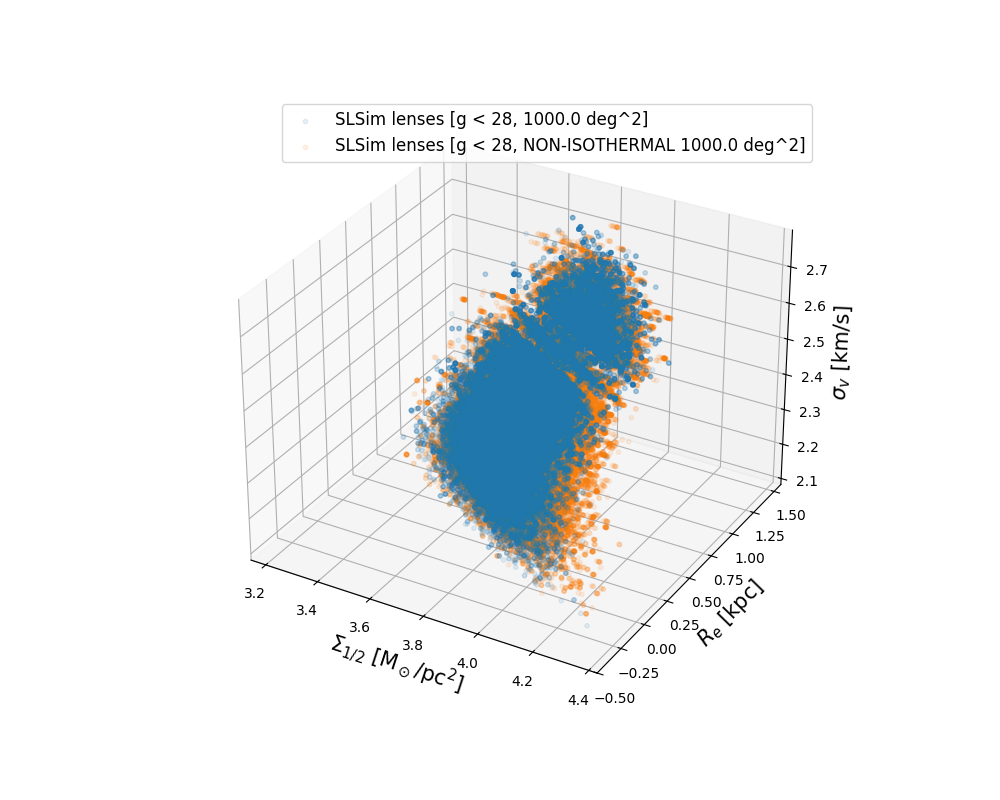

In [3]:
# 3D MFP
%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for area, GGL_data_table in GGL_data_tables.items():
    ax.scatter(
        np.log10(GGL_data_table['Sigma_half_Msun/pc2']), 
        np.log10(GGL_data_table['R_e_kpc']), 
        np.log10(GGL_data_table['sigma_v_D']), 
        s=10, alpha=0.1, 
        label=f'SLSim lenses [g < 28, {area} deg^2]'
    )
ax.set_xlabel('$\\Sigma_{1/2}$ [M$_\\odot$/pc$^2$]', fontsize=15)
ax.set_ylabel('$R_e$ [kpc]', fontsize=15)
ax.set_zlabel('$\\sigma_v$ [km/s]', fontsize=15)
ax.legend(fontsize=12)

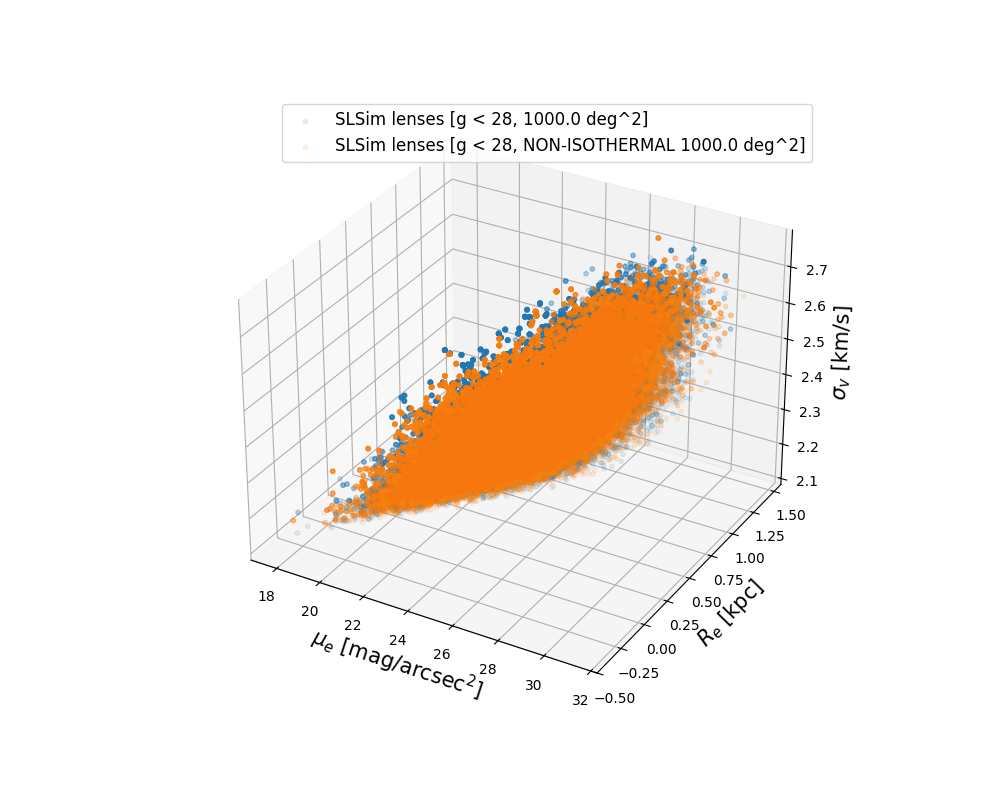

In [4]:
# 3D MFP
%matplotlib widget

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for area, GGL_data_table in GGL_data_tables.items():
    ax.scatter(
        GGL_data_table['surf_bri_mag/arcsec2'], 
        np.log10(GGL_data_table['R_e_kpc']), 
        np.log10(GGL_data_table['sigma_v_D']), 
        s=10, alpha=0.1, 
        label=f'SLSim lenses [g < 28, {area} deg^2]'
    )
ax.set_xlabel('$\\mu_e$ [mag/arcsec$^2$]', fontsize=15)
ax.set_ylabel('$R_e$ [kpc]', fontsize=15)
ax.set_zlabel('$\\sigma_v$ [km/s]', fontsize=15)
ax.legend(fontsize=12)

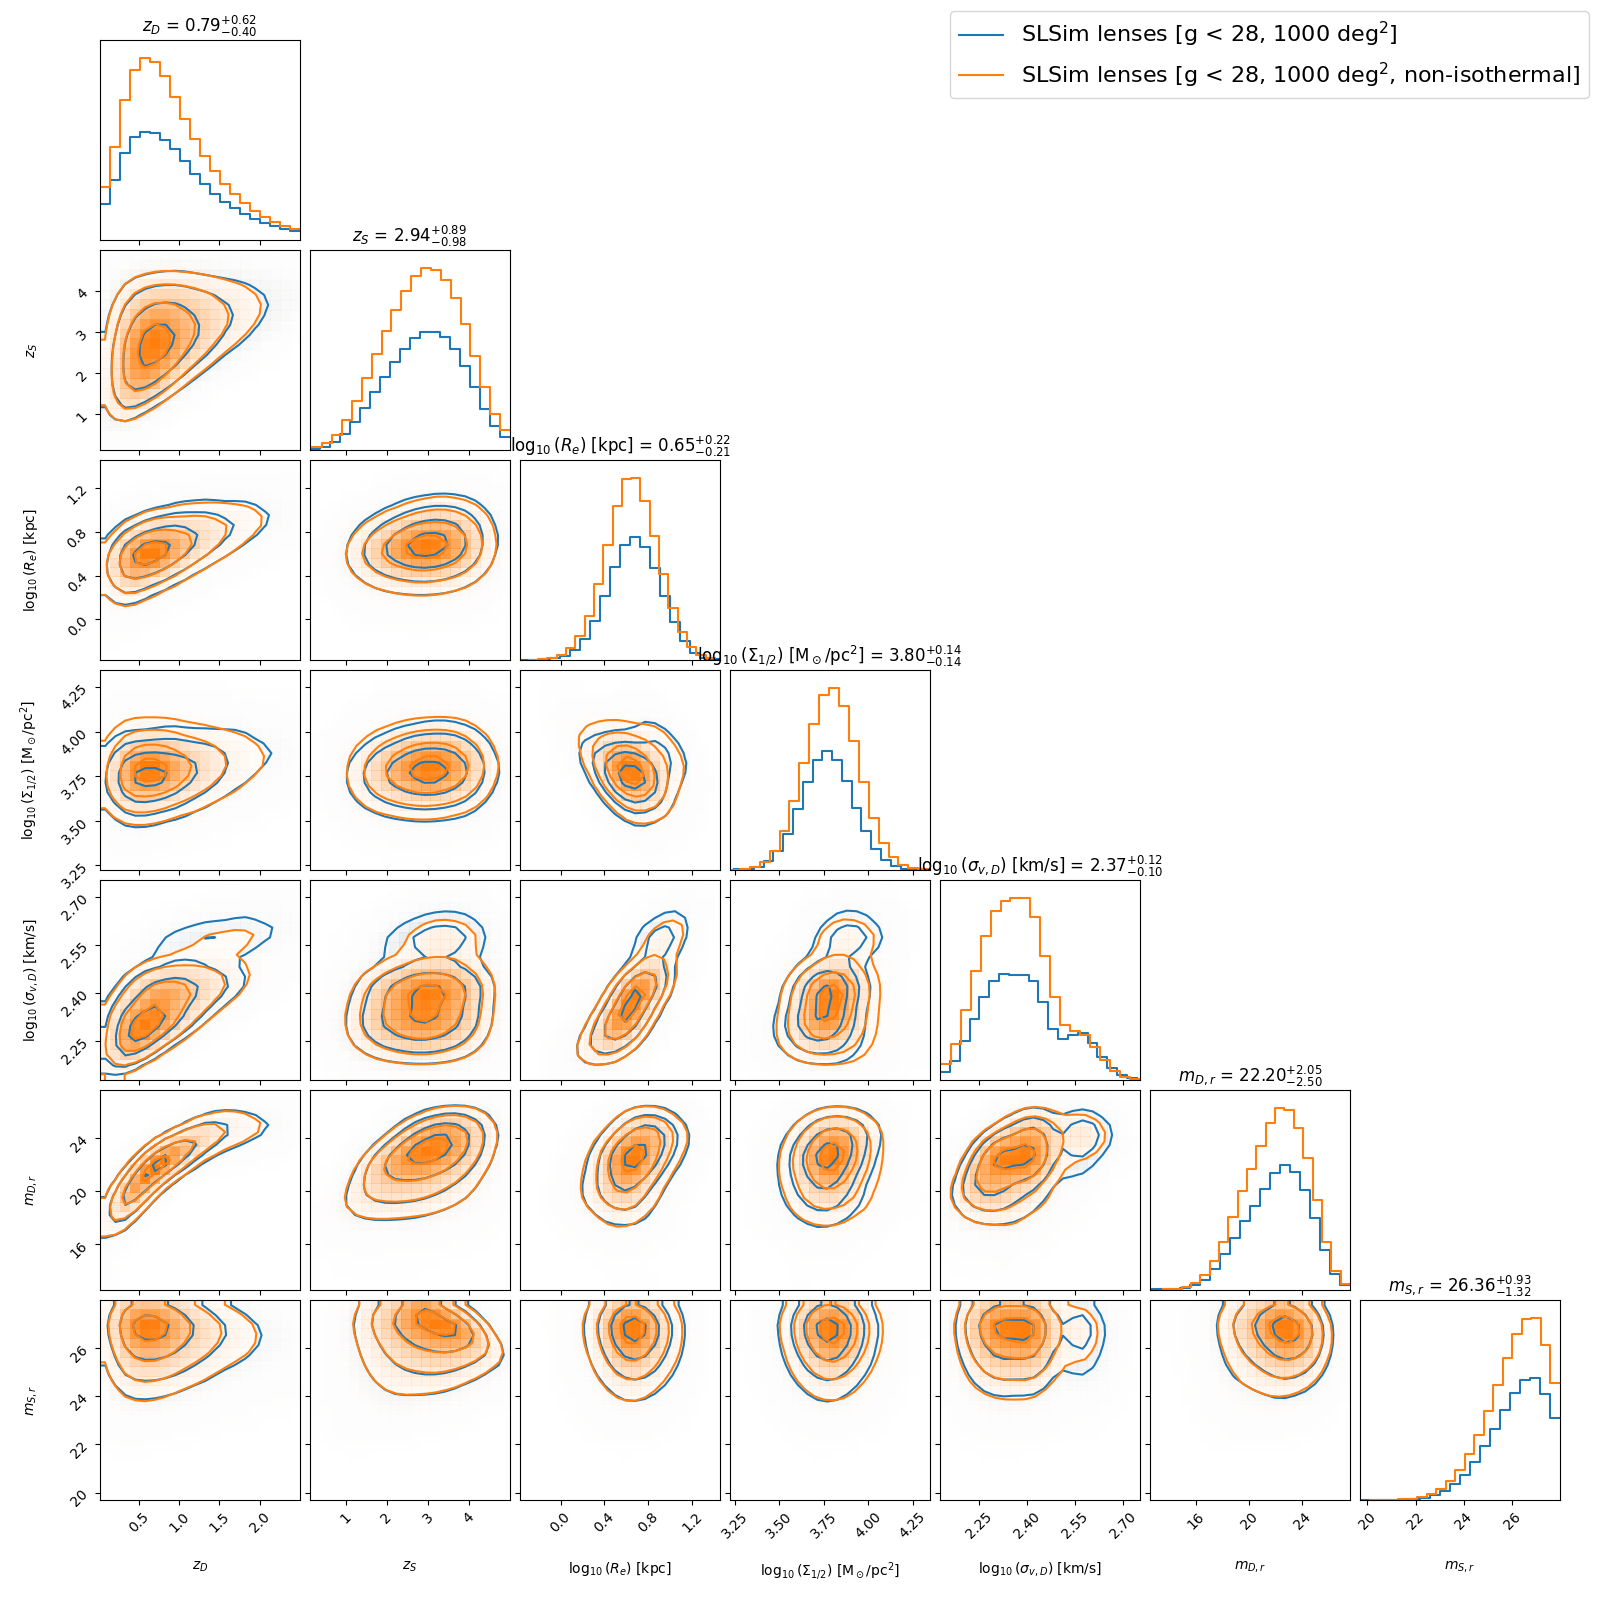

In [5]:

#### Make corner plot of the Original GGLs generated by SLSim
key_list = ['z_D',
            'z_S',
            'log_R_e_kpc', 
            'log_Sigma_half_Msun/pc2', 
            'log_sigma_v_D', 
            'mag_D_r', 
            'mag_S_r']
key_latex_labels = {
    'z_D': r'$z_D$',
    'z_S': r'$z_S$',
    'log_R_e_kpc': r'$\log_{10}(R_e)$ [kpc]',
    'log_Sigma_half_Msun/pc2': r'$\log_{10}(\Sigma_{1/2})$ [M$_\odot$/pc$^2$]',
    'log_sigma_v_D': r'$\log_{10}(\sigma_{v, D})$ [km/s]',
    'mag_D_r': r'$m_{D, r}$',
    'mag_S_r': r'$m_{S, r}$'
}

data_corners = {}
for area, GGL_data_table in GGL_data_tables.items():
    data_corner = [GGL_data_table[key] for key in key_list]
    data_corner = np.array(data_corner).T
    data_corners[area] = data_corner


fig_corner = corner.corner(
    data_corners['1000.0'],
    labels=[key_latex_labels[key] for key in key_list],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    color='C0',
);

corner.corner(
    data_corners['NON-ISOTHERMAL 1000.0'],
    labels=[key_latex_labels[key] for key in key_list],
    show_titles=True,
    smooth=True,
    smooth1d=True,
    plot_datapoints=False,
    fig=fig_corner,
    color='C1',
);


fig_corner.legend(
    ['SLSim lenses [g < 28, 1000 deg$^2$]', 'SLSim lenses [g < 28, 1000 deg$^2$, non-isothermal]'],
    loc='upper right',
    fontsize=16
)

# make the font size of the labels and titles larger
# for ax in fig_corner.get_axes():
#     ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.set_xlabel(ax.get_xlabel(), fontsize=16)
#     ax.set_ylabel(ax.get_ylabel(), fontsize=16)
#     ax.set_title(ax.get_title(), fontsize=16)

1000.0 deg$^2$ sigma_v scatter (MFP): 0.47946770006509287 %
NON-ISOTHERMAL 1000.0 deg$^2$ sigma_v scatter (MFP): 1.5869874998352924 %


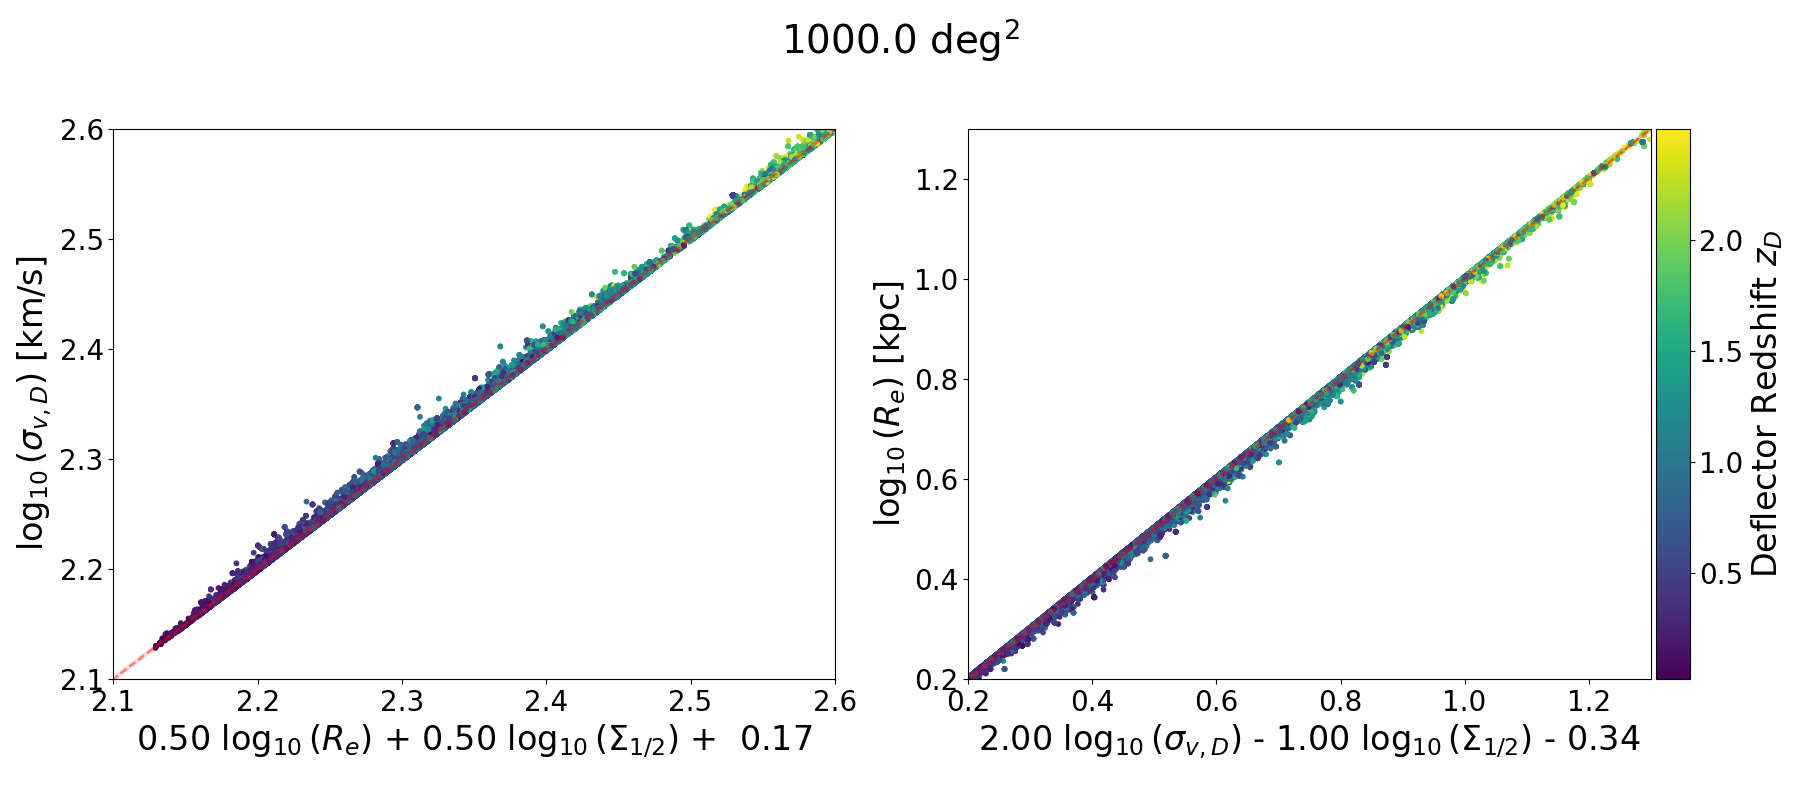

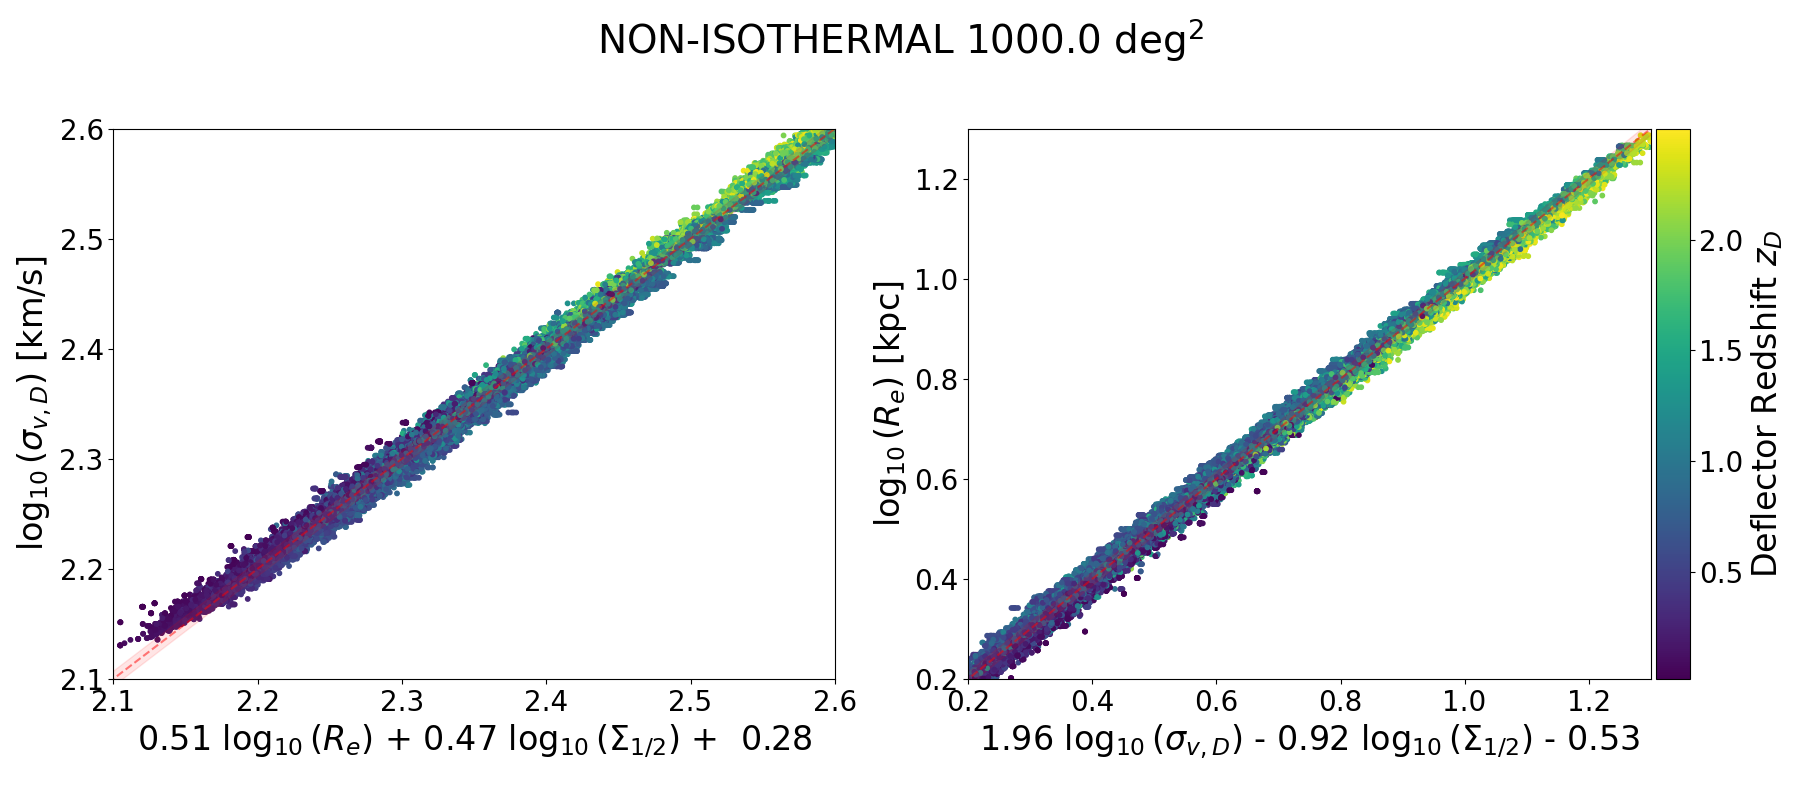

In [6]:
# MFP for the original data at different depths

title_list = [
    f"{area} deg$^2$" for area in GGL_data_tables.keys()
]
i = 0
for data_table in GGL_data_tables.values():
    # fit the MFP
    coeffs_MFP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_MFP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["sigma_v_D"]),
        coeffs_MFP,
        return_fit=False
    )

    # fit the MFP with R_e as the dependent variable
    coeffs_MFP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_MFP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        np.log10(data_table["Sigma_half_Msun/pc2"]),
        np.log10(data_table["R_e_kpc"]),
        coeffs_MFP_alt,
        return_fit=False
    )

    # print the scatter in percentage
    print(title_list[i], "sigma_v scatter (MFP):", np.std(scatter_MFP) * np.log(10) * 100, "%")
    # print(title_list[i], "scatter (MFP alt):", np.std(scatter_MFP_alt) * np.log(10) * 100, "%")

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_MFP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_MFP[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_MFP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_MFP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_MFP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_MFP),
                        y_faded + np.std(scatter_MFP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_MFP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_MFP_alt[1] * np.log10(data_table["Sigma_half_Msun/pc2"]) + 
        coeffs_MFP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim MFP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_MFP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_MFP_alt[1] > 0 else '-'} {np.abs(coeffs_MFP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_MFP_alt[2] > 0 else '-'} {np.abs(coeffs_MFP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_MFP_alt),
                        y_faded + np.std(scatter_MFP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2.1, 2.6)
    axs[0].set_ylim(2.1, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_MFP.pdf", bbox_inches='tight', dpi=300)

1000.0 deg$^2$ sigma_v scatter (FP): 14.809811154572328 %
NON-ISOTHERMAL 1000.0 deg$^2$ sigma_v scatter (FP): 13.647326404427437 %


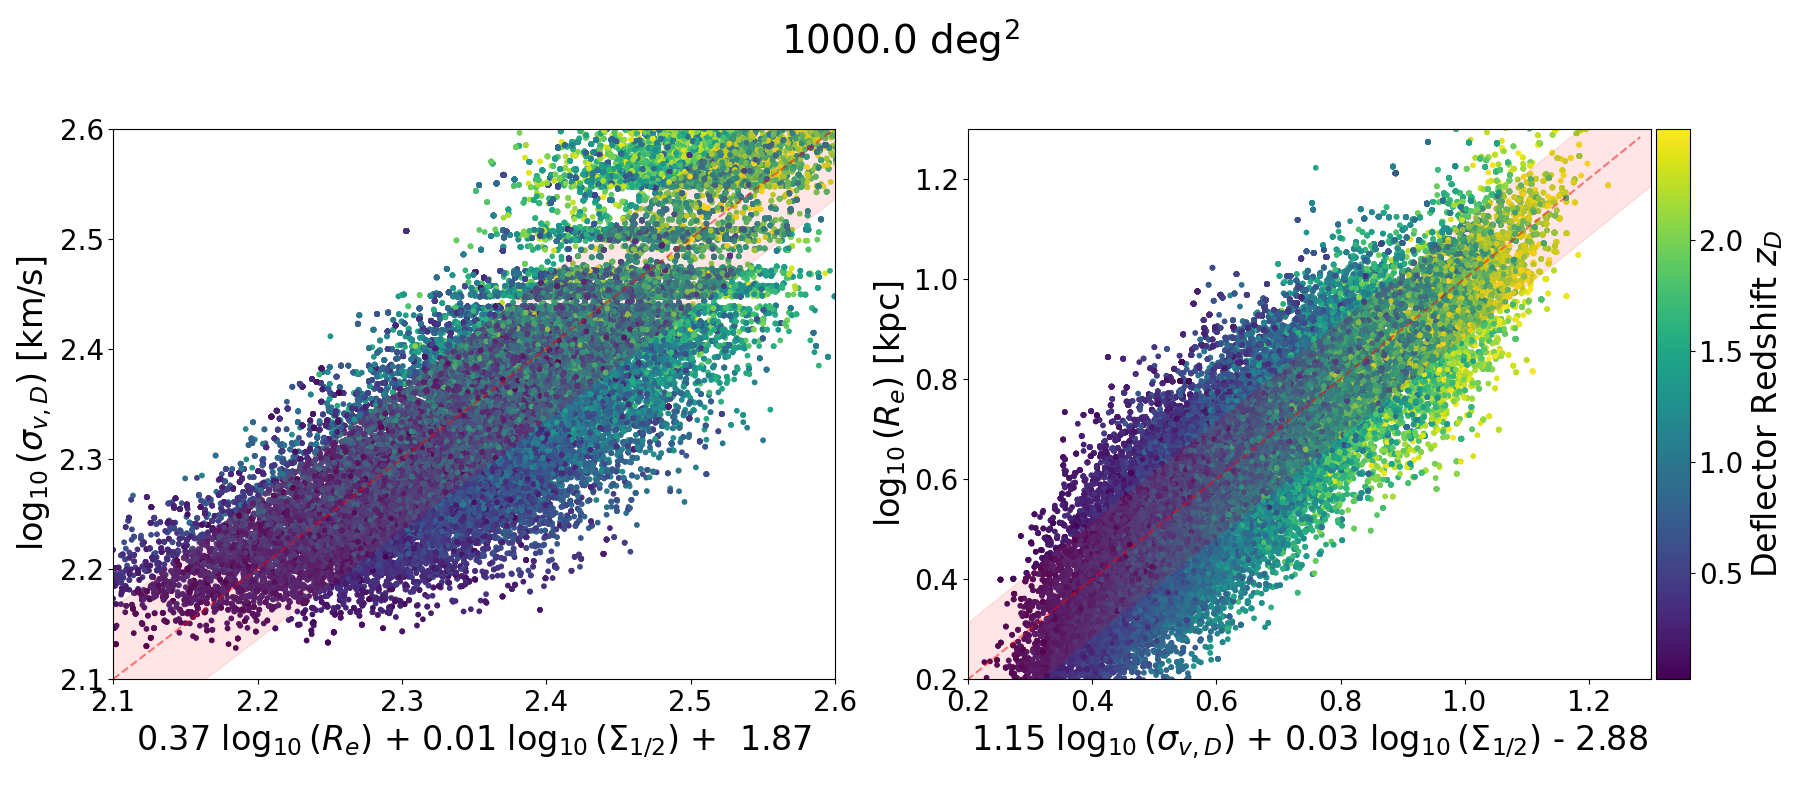

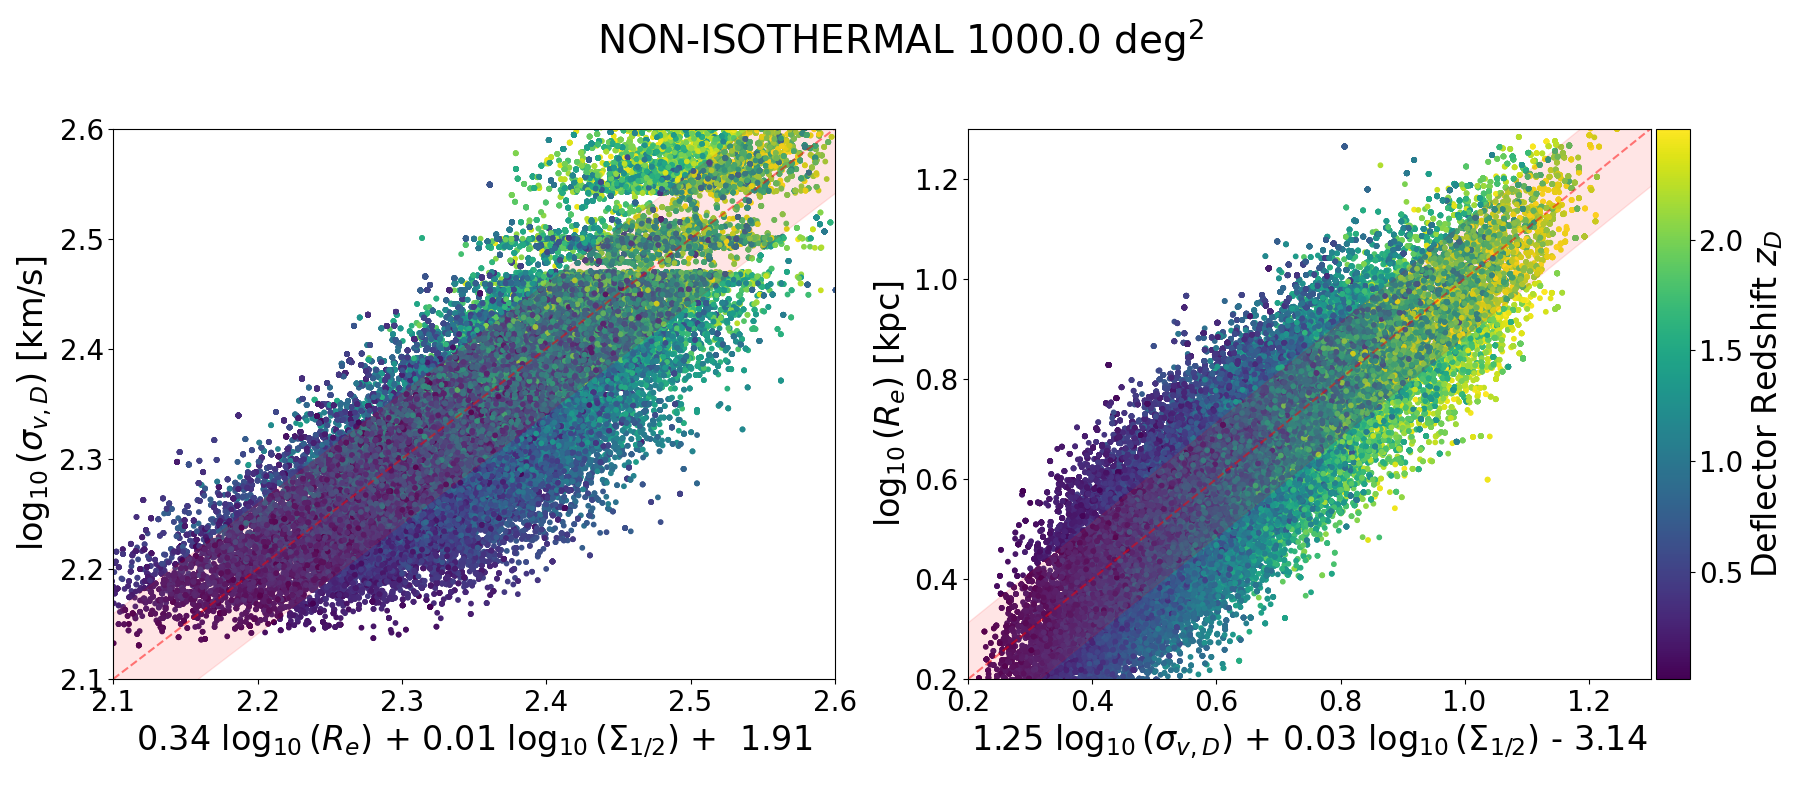

In [7]:
# FP for the original data at different depths

title_list = [
    f"{area} deg$^2$" for area in GGL_data_tables.keys()
]
i = 0
for data_table in GGL_data_tables.values():
    # fit the FP
    coeffs_FP = fit_plane(
        np.log10(data_table["R_e_kpc"]),
        data_table['surf_bri_mag/arcsec2'],
        np.log10(data_table["sigma_v_D"])
    )

    # find the scatter
    scatter_FP = find_scatter(
        np.log10(data_table["R_e_kpc"]),
        data_table['surf_bri_mag/arcsec2'],
        np.log10(data_table["sigma_v_D"]),
        coeffs_FP,
        return_fit=False
    )

    # fit the FP with R_e as the dependent variable
    coeffs_FP_alt = fit_plane(
        np.log10(data_table["sigma_v_D"]),
        data_table['surf_bri_mag/arcsec2'],
        np.log10(data_table["R_e_kpc"])
    )

    # find the scatter
    scatter_FP_alt = find_scatter(
        np.log10(data_table["sigma_v_D"]),
        data_table['surf_bri_mag/arcsec2'],
        np.log10(data_table["R_e_kpc"]),
        coeffs_FP_alt,
        return_fit=False
    )

    # print the scatter in percentage
    print(title_list[i], "sigma_v scatter (FP):", np.std(scatter_FP) * np.log(10) * 100, "%")
    # print(title_list[i], "scatter (FP alt):", np.std(scatter_FP_alt) * np.log(10) * 100, "%")

    # side-by-side plot of the two fundamental planes
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    # sigma_v fundamental plane
    axs[0].scatter(
        coeffs_FP[0] * np.log10(data_table["R_e_kpc"]) + 
        coeffs_FP[1] * data_table['surf_bri_mag/arcsec2'] + 
        coeffs_FP[2],
        np.log10(data_table["sigma_v_D"]),
        c=data_table["z_D"], s=10, label='SLSim FP', 
        cmap='viridis'
    )
    axs[0].set_xlabel(f'{coeffs_FP[0]:.2f} ' + r'$\log_{10}(R_e)$ + ' + f'{coeffs_FP[1]:.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ + ' + f' {coeffs_FP[2]:.2f}')
    axs[0].set_ylabel(r'$\log_{10}(\sigma_{v, D})$ [km/s]')
    # axs[0].set_title('SLSim Mass Fundamental Plane', fontsize=16)

    # Plot the fitted plane with a faded scatter
    # y = x
    axs[0].plot([axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                [axs[0].get_xlim()[0], axs[0].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[0].get_xlim()[0], axs[0].get_xlim()[1], 100)
    y_faded = x_faded
    axs[0].fill_between(x_faded, y_faded - np.std(scatter_FP),
                        y_faded + np.std(scatter_FP), color='red', alpha=0.1)

    # R_e fundamental plane
    scatter_plot = axs[1].scatter(
        coeffs_FP_alt[0] * np.log10(data_table["sigma_v_D"]) + 
        coeffs_FP_alt[1] * data_table['surf_bri_mag/arcsec2'] + 
        coeffs_FP_alt[2],
        np.log10(data_table["R_e_kpc"]),
        c=data_table["z_D"], s=10, label='SLSim FP', 
        cmap='viridis'
    )
    axs[1].set_xlabel(f'{coeffs_FP_alt[0]:.2f} ' + r'$\log_{10}(\sigma_{v, D})$ ' + f'{'+' if coeffs_FP_alt[1] > 0 else '-'} {np.abs(coeffs_FP_alt[1]):.2f} ' + r'$\log_{10}(\Sigma_{1/2})$ ' + f'{'+' if coeffs_FP_alt[2] > 0 else '-'} {np.abs(coeffs_FP_alt[2]):.2f}')
    axs[1].set_ylabel(r'$\log_{10}(R_e)$ [kpc]')
    # axs[1].set_title('SLSim Mass Fundamental Plane', fontsize=16)
    # Plot the fitted plane with a faded scatter
    # y = x
    axs[1].plot([axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                [axs[1].get_xlim()[0], axs[1].get_xlim()[1]],
                color='red', linestyle='--', alpha=0.5, label='y = x')
    # faded region for the scatter
    x_faded = np.linspace(axs[1].get_xlim()[0], axs[1].get_xlim()[1], 100)
    y_faded = x_faded
    axs[1].fill_between(x_faded, y_faded - np.std(scatter_FP_alt),
                        y_faded + np.std(scatter_FP_alt), color='red', alpha=0.1)

    # common colorbar
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(scatter_plot, cax=cax)
    cbar.set_label('Deflector Redshift $z_D$', fontsize=14)


    # increase the font size of the labels and title
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.set_xlabel(ax.get_xlabel(), fontsize=24)
        ax.set_ylabel(ax.get_ylabel(), fontsize=24)
        ax.set_title(ax.get_title(), fontsize=24)
        # ax.legend(fontsize=14)

    # cbar label size
    cbar.ax.set_ylabel(cbar.ax.get_ylabel(), fontsize=24)

    # cbar tick labels
    cbar.ax.tick_params(labelsize=20)

    axs[0].set_xlim(2.1, 2.6)
    axs[0].set_ylim(2.1, 2.6)
    axs[1].set_xlim(0.2, 1.3)
    axs[1].set_ylim(0.2, 1.3)

    fig.suptitle(title_list[i], fontsize=28)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    i += 1

# save the figure
# fig.savefig(f"../figures/slsim_FP.pdf", bbox_inches='tight', dpi=300)